In [1]:
import numpy as np
seeds = [20251106, 20251108]

In [2]:
import pandas as pd

N = 1500
K = 2
noise = 0.0

X_noisy = pd.read_csv(f"./baselines/data/swiss_noise_{noise}.csv").values
t = X_noisy[:, 3]
X_noisy = X_noisy[:, :3]
X = X_noisy

## Data Generation

Here's a plot of the swiss roll data.

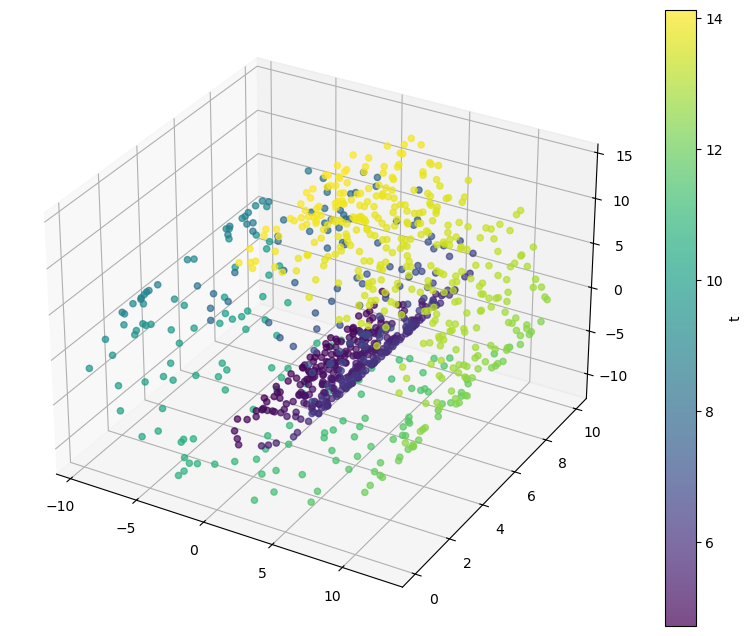

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_noisy[:, 0], X_noisy[:, 1], X_noisy[:, 2], c=t, s=20, alpha=0.7, cmap='viridis')
plt.colorbar(sc, ax=ax, label='t')
plt.show()

In [4]:
import altair as alt
import pandas as pd

def plot_swiss_emb(X_emb, t):
    df_emb = pd.DataFrame(X_emb, columns=['x', 'y'])
    df_emb["t"] = t
    return alt.Chart(df_emb).mark_circle(size=60).encode(
        x='x',
        y='y',
        color='t'
    ).properties(width=400, height=300)

## $t$-SNE Distortions

In [5]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=100, random_state=seeds[0], learning_rate='auto') # set to init='random' for more variation
Z1 = tsne.fit_transform(X_noisy)

tsne = TSNE(n_components=2, perplexity=100, random_state=seeds[1], learning_rate='auto')
Z2 = tsne.fit_transform(X_noisy)

Apply procrustes to align the two embeddings.

In [6]:
from scipy.linalg import orthogonal_procrustes

Z1 = Z1 - Z1.mean(axis=0)
Z2 = Z2 - Z2.mean(axis=0)
R, scale = orthogonal_procrustes(Z2, Z1)
Z2 = Z2 @ R

In [7]:
plots = [
    plot_swiss_emb(Z1, t),
    plot_swiss_emb(Z2, t)
]

[display(p) for p in plots]

alt.Chart(...)

alt.Chart(...)

[None, None]

In [8]:
from distortions.geometry import Geometry, bind_metric, local_distortions, neighborhoods
from distortions.visualization import dplot
from anndata import AnnData
from sklearn.neighbors import NearestNeighbors

def distortion_plot(Z, X, t, n_neighbors=40, geom_radius=1, threshold=0.1, outlier_factor=2):
    adata = AnnData(X=X)
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean").fit(X)
    knn_graph = nn.kneighbors_graph(X, mode="distance")
    adata.obsp["distances"] = knn_graph
    adata.obsm["X_tsne"] = Z

    geom_radius = 0.5 * np.mean(adata.obsp["distances"].data)
    geom = Geometry(affinity_kwds={"radius": geom_radius}, adjacency_kwds={"n_neighbors": n_neighbors})
    H, Hvv, Hs = local_distortions(Z, X, geom)
    hq = np.quantile(Hs, 0.99)
    Hs[Hs > hq] = hq
    embedding = bind_metric(Z, Hvv, Hs)
    embedding["t"] = t

    N = neighborhoods(adata, threshold=threshold, outlier_factor=outlier_factor, embed_key="X_tsne")

    pal = ['#B776A6', '#BAC4A2']
    plot = dplot(embedding, height=350, width=450)\
        .mapping(x="embedding_0", y="embedding_1", color="t")\
        .inter_edge_link(N=N, strokeWidth=.2, opacity=0.9, threshold=10, stroke="#363E59", highlightColor="#363E59", backgroundOpacity=0.6)\
        .geom_ellipse(radiusMin=1, radiusMax=10)\
        .labs(x='t-SNE 1', y='t-SNE 2')\
        .scale_color(scheme=pal)

    return plot, H, embedding, N

In [9]:
import time
start_time = time.time()
display(distortion_plot(Z1, X_noisy, t)[0])
elapsed = time.time() - start_time
with open(f"baselines/data/runtime_dist_{noise}.txt", "w") as f:
    f.write(str(elapsed))

dplot(dataset=[{'embedding_0': -17.553518295288086, 'embedding_1': -4.967970371246338, 'x0': -0.97378945252753…

In [10]:
distortion_data = [
    distortion_plot(Z1, X_noisy, t),
    distortion_plot(Z2, X_noisy, t)
]

[display(p[0]) for p in distortion_data]

dplot(dataset=[{'embedding_0': -17.553518295288086, 'embedding_1': -4.967970371246338, 'x0': -0.97378945252753…

dplot(dataset=[{'embedding_0': -17.55352020263672, 'embedding_1': -4.967971324920654, 'x0': -0.973802412845542…

[None, None]

In [11]:
save_dir = "/Users/krissankaran/Desktop/collaborations/distortions-project/distortions-dev/paper/figures/"
#distortion_data[0][0].save(f"{save_dir}/swiss_roll_baseline_no_interact_{noise}.svg")
#distortion_data[0][0].save(f"{save_dir}/swiss_roll_baseline_interact_{noise}.svg")

## Neighbor Distance Preservation

In [12]:
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors

# Compute pairwise distances in embedding spaces, then the ratio matrix
D1 = cdist(Z1, Z1)
D2 = cdist(Z2, Z2)
R = D1 / D2
R_inv = D2 / D1

# Compute nearest neighbors in original space X
n_neighbors = 15
nn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean').fit(X)
knn_indices = nn.kneighbors(X, return_distance=False)

# Build mask M: M[i, j] = 1 if j is among i's nearest neighbors (excluding self)
n = X.shape[0]
M = np.zeros((n, n), dtype=int)
for i in range(n):
    for j in knn_indices[i][1:]:  # skip self (first neighbor)
        M[i, j] = 1

# For each row, compute variance of R[i, j] over j where M[i, j] == 1
# Compute analogous V_inv for R_inv.
V = np.array([np.var(R[i][M[i]==1]) for i in range(n)])
V_inv = np.array([np.var(R_inv[i][M[i]==1]) for i in range(n)])
V_max = np.maximum(V, V_inv)

In [13]:
alt.data_transformers.enable("vegafusion")

# Flatten R to a 1D array and create a DataFrame for plotting
R_flat = R.flatten()
R_df = pd.DataFrame({'R': np.log10(R_flat)})

alt.Chart(R_df).mark_bar().encode(
    alt.X('R', bin=alt.Bin(maxbins=100), title='Distance Ratio R (log_{10})'),
    alt.Y('count()', title='Frequency')
).properties(
    width=400, height=250,
    title='Histogram of Distance Ratios log_{10}(R)'
)

alt.Chart(...)

In [14]:
from scipy.linalg import fractional_matrix_power, logm

Hs1 = distortion_data[0][1]  # shape: (n, 2, 2)
Hs2 = distortion_data[1][1]
norm = 'fro'
H_instability = np.linalg.norm(Hs1 - Hs2, ord=norm, axis=(1, 2))
Hs1_norm = np.linalg.norm(Hs1, ord=norm, axis=(1, 2))
Hs2_norm = np.linalg.norm(Hs2, ord=norm, axis=(1, 2))

stability_data = pd.DataFrame({
    "v_d": V_max,
    "n_H": H_instability / (Hs1_norm * Hs2_norm),
    "t": t
})

# Compute n_H_det: |det(Hs1[i]^{-1} @ Hs2[i])| for each i
n = Hs1.shape[0]
n_H_det = np.empty(n)
for i in range(n):
    n_H_det[i] = np.abs(np.log(np.linalg.det(Hs1[i])) - np.log(np.linalg.det(Hs2[i])))
stability_data["n_H_det"] = n_H_det

n_H_sim = np.empty(n)
for i in range(n):
    H1_inv_sqrt = fractional_matrix_power(Hs1[i], -0.5)
    sim = H1_inv_sqrt @ Hs2[i] @ H1_inv_sqrt
    sim_log = logm(sim)
    n_H_sim[i] = 0.5 * np.linalg.norm(sim_log, ord='fro')
stability_data["n_H_sim"] = n_H_sim

In [15]:
n = Hs1.shape[0]
HH_sv = np.empty(n)
for i in range(n):
    U, s, Vh = np.linalg.svd(np.linalg.inv(Hs1[i]) @ Hs2[i])
    HH_sv[i] = np.max(np.abs(np.sqrt(s) - 1))
stability_data["HH_sv"] = HH_sv

In [16]:
N_keys_0 = set([k - 1 for k in distortion_data[0][3].keys()])
stability_data["distorted"] = stability_data.index.isin(N_keys_0)

In [17]:
embedding_list = [p[2] for p in distortion_data]
groups = ["seed1", "seed2"]
for emb, group in zip(embedding_list, groups):
    emb["sample"] = embedding_list[0].index
    emb["group"] = group
    emb["V"] = np.log(V_max)

In [18]:
combined_embedding = pd.concat(embedding_list)
plot_var = dplot(combined_embedding, height = 350, width=450)\
    .mapping(x="embedding_0", y="embedding_1", color="V")\
    .geom_ellipse(opacity=0.9, radiusMin=1, radiusMax=20, stroke=True)\
    .scale_color(stroke=True)\
    .labs(x="UMAP1", y="UMAP2")

plot_group = dplot(combined_embedding, height = 350, width=450)\
    .mapping(x="embedding_0", y="embedding_1", color="group")\
    .geom_ellipse(opacity=0.9, radiusMin=1, radiusMax=20, stroke=True)\
    .scale_color(stroke=True, scheme=["green", "purple"])\
    .labs(x="UMAP1", y="UMAP2")

In [19]:
plot_var

dplot(dataset=[{'embedding_0': -17.553518295288086, 'embedding_1': -4.967970371246338, 'x0': -0.97378945252753…

In [20]:
plot_group

dplot(dataset=[{'embedding_0': -17.553518295288086, 'embedding_1': -4.967970371246338, 'x0': -0.97378945252753…

In [21]:
#plot_var.save("/Users/krissankaran/Downloads/v3.svg")
plot_group.save("/Users/krissankaran/Downloads/v4.svg")

In [22]:
def make_stability_scatter(y, y_title=None, y_scale='log', color='distorted', color_title=None, color_range=None, size=20):
    if y_title is None:
        y_title = y
    if color_title is None:
        color_title = color

    # Split data for overlay
    df_black = stability_data[stability_data[color] == False]
    df_red = stability_data[stability_data[color] == True]

    enc = [
        alt.X('v_d', title="SD of $d_i/d'_i$ ratios among neighbors", scale=alt.Scale(type='log')),
        alt.Y(y, title=y_title, scale=alt.Scale(type=y_scale)),
    ]
    scatter_black = alt.Chart(df_black).mark_circle(size=size, color='black').encode(*enc)
    scatter_red = alt.Chart(df_red).mark_circle(size=size, color='red').encode(*enc)

    line_data = pd.DataFrame({
        'v_d': np.linspace(stability_data['v_d'].min(), stability_data['v_d'].max(), 100)
    })
    line_data[y] = line_data['v_d']
    line = alt.Chart(line_data).mark_line(color='gray', strokeDash=[4,4]).encode(
        x='v_d',
        y=y
    )
    return (scatter_black + scatter_red + line).properties(
        width=400, height=300,
        title=f'Neighbor Preservation vs. Distortion Stability: {y_title}'
    )

In [23]:
stability_data

,v_d,n_H,t,n_H_det,n_H_sim,HH_sv,distorted
0,3.574513e-18,0.001657,11.489719,0.000073,0.000073,0.000074,False
1,3.146408e-14,0.000024,6.187302,0.000005,0.000002,0.000002,False
2,1.894028e-14,0.003019,10.729005,0.000256,0.000101,0.000097,False
3,7.504273e-15,0.000091,7.555652,0.000019,0.000010,0.000012,True
4,2.735290e-15,0.000602,8.282046,0.000035,0.000018,0.000022,False
...,...,...,...,...,...,...,...
935,1.630904e-14,0.000056,13.811979,0.000040,0.000021,0.000021,False
936,3.844885e-14,0.000042,13.368451,0.000010,0.000011,0.000010,False
937,7.932017e-14,0.000026,13.001232,0.000010,0.000004,0.000004,False
938,1.314958e-14,0.000181,12.456238,0.000022,0.000016,0.000016,False


In [24]:
# Frobenius norm of log-matrix similarity
plot_n_H_sim = make_stability_scatter(
    y='n_H_sim',
    y_title="(1/2) * ||\\log H^{-1/2} (H') H^{-1/2}||_{F}",
    color='distorted',
    color_range=['black', 'red'],
    size=20
)

# Absolute log-determinant difference
plot_n_H_det = make_stability_scatter(
    y='n_H_det',
    y_title="|\\log|H| - \\log|H'||",
    color='distorted',
    color_range=['black', 'red'],
    size=20
)

plot_n_H = make_stability_scatter(
    y='n_H',
    y_title="normalized ||H - H'||_{F}",
    color='distorted',
    color_range=['black', 'red'],
    size=20
)

# Singular value difference
plot_HH_sv = make_stability_scatter(
    y='HH_sv',
    y_title="\max(|\sqrt{\lambda_1}-1|,|\sqrt{\lambda_2}-1|)",
    color='distorted',
    color_range=['black', 'red'],
    size=20
)

In [25]:
plot_n_H_sim.save("/Users/krissankaran/Downloads/n_H_sim.png")
plot_n_H_det.save("/Users/krissankaran/Downloads/n_H_det.png")
plot_HH_sv.save("/Users/krissankaran/Downloads/HH_sv.png")
plot_n_H.save("/Users/krissankaran/Downloads/n_H.png")

In [26]:
def make_t_scatter(metric, title, scale_type='log', size=40):
    df_plot = stability_data.sort_values("distorted", ascending=True)
    return alt.Chart(df_plot).mark_circle(size=size).encode(
        x=alt.X(
            't',
            title='Swiss Roll Parameter',
            scale=alt.Scale(domain=[df_plot['t'].min(), df_plot['t'].max()])
        ),
        y=alt.Y(metric, scale=alt.Scale(type=scale_type), title = title),
        color=alt.Color('distorted:N', title='Distorted', scale=alt.Scale(domain=[False, True], range=['black', 'red']))
    ).properties(width=400, height=300)

In [27]:
make_t_scatter('n_H_sim', "(1/2) * ||\\log H^{-1/2} (H') H^{-1/2}||_{F}")

alt.Chart(...)

In [28]:
make_t_scatter('HH_sv', "max(|\sqrt{\lambda_1}-1|,|\sqrt{\lambda_2}|)")

alt.Chart(...)